In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from vnstock3 import Vnstock
import matplotlib.pyplot as plt

In [ ]:
# prompt: fixed the random seed of pytorch

torch.manual_seed(42)


#### Define the TimeSeriesDataset class

In [46]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data: torch.Tensor, seq_len: int, future_len: int):
        self.data = data
        self.seq_len = seq_len
        self.future_len = future_len
        self.Scaler = StandardScaler()
        self.scaled_data = torch.tensor(self.Scaler.fit_transform(self.data.cpu().numpy()))
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.future_len

    def __getitem__(self, i):
        if i < 0:
            i = self.__len__() + i
        
        seq = self.scaled_data[i : i + self.seq_len]
        label = self.scaled_data[i + self.seq_len: i + self.seq_len + self.future_len, -2]
        truth = self.data[i + self.seq_len: i + self.seq_len + self.future_len, -2]
        return {
            "seq": seq.clone().detach().float(),
            "label": label.clone().detach().float(),
            "truth": truth.clone().detach().float(),
        }


#### Load the data

In [ ]:
Vnstock().stock(symbol="BID", source="VCI").finance.ratio(period="month", lang="en")

In [47]:
# Load data from Vnstock3
seq_len = 100
future_len = 10
symbol = "DCM"
stock = Vnstock().stock(symbol=symbol, source='VCI')
df = stock.quote.history(start='2014-01-01', end='2024-06-21', interval='1D')
datatime = pd.to_datetime(df["time"])
data = {}
data[symbol] = torch.tensor(df.iloc[:, 1:].values)
dataset = TimeSeriesDataset(data[symbol], seq_len=seq_len, future_len=future_len)

2024-10-20 17:49:41,000 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [48]:
torch.set_printoptions(profile="full", sci_mode=False)
print(dataset[-210])


{'seq': tensor([[     0.6622,      0.7047,      0.7038,      0.7304,      0.5612],
        [     0.7315,      0.7008,      0.7223,      0.6912,      0.2140],
        [     0.7185,      0.6919,      0.7440,      0.7173,      0.0791],
        [     0.6843,      0.6713,      0.6956,      0.6650,     -0.2236],
        [     0.6974,      0.6752,      0.7038,      0.7173,      1.7290],
        [     0.7144,      0.7351,      0.7306,      0.7697,      0.4931],
        [     0.7797,      0.7430,      0.7707,      0.7606,      0.1861],
        [     0.7707,      0.7685,      0.8016,      0.7828,      0.6117],
        [     0.7757,      0.7518,      0.8067,      0.7828,     -0.2532],
        [     0.7928,      0.7518,      0.7800,      0.7395,      0.2491],
        [     0.7405,      0.7263,      0.7666,      0.7657,     -0.3541],
        [     0.7837,      0.7430,      0.7934,      0.7526,     -0.0977],
        [     0.7626,      0.7224,      0.7707,      0.7526,     -0.4726],
        [     0.7

In [60]:
train_dataset, test_dataset = random_split(dataset, [0.6, 0.4])

print(len(train_dataset), len(test_dataset))
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

1320 879


In [ ]:
data = {}
dir_path = "/content/TimeSeriesStock/data"
for csv_file in os.listdir(dir_path):
    if not csv_file.endswith(".csv"):
        continue
    print(f"Processing {csv_file}")
    file = open(f"{dir_path}/{csv_file}", "r")

    stock_name = csv_file.split(".")[0]
    df = pd.read_csv(
        file,
        header=1,
        names=["ticker", "date", "open", "high", "low", "close", "volume"],
    )
    df = df.sort_values(by="date", ascending=True)

    datatime = pd.to_datetime(df["date"], format="%Y%m%d")
    df["year"] = datatime.dt.year
    df["month"] = datatime.dt.month
    df["day"] = datatime.dt.day

    print(f"Number of unique dates in {csv_file}: {df['date'].nunique()}")
    data[stock_name] = torch.tensor(df.iloc[:, 2:].values)

    file.close()


Processing MSN.csv
Number of unique dates in MSN.csv: 2901
Processing GAS.csv
Number of unique dates in GAS.csv: 2271
Processing VRE.csv
Number of unique dates in VRE.csv: 903
Processing FPT.csv
Number of unique dates in FPT.csv: 3617
Processing NVL.csv
Number of unique dates in NVL.csv: 1119
Processing VNM.csv
Number of unique dates in VNM.csv: 3841
Processing REE.csv
Number of unique dates in REE.csv: 5055
Processing VHM.csv
Number of unique dates in VHM.csv: 777
Processing MBB.csv
Number of unique dates in MBB.csv: 2406
Processing POW.csv
Number of unique dates in POW.csv: 819
Processing PDR.csv
Number of unique dates in PDR.csv: 2578
Processing HDB.csv
Number of unique dates in HDB.csv: 863
Processing VCB.csv
Number of unique dates in VCB.csv: 2990
Processing BID.csv
Number of unique dates in BID.csv: 1846
Processing PLX.csv
Number of unique dates in PLX.csv: 1044
Processing STB.csv
Number of unique dates in STB.csv: 3726
Processing VJC.csv
Number of unique dates in VJC.csv: 1081
P


#### Create the dataset and dataloader

In [ ]:
dataset = TimeSeriesDataset(data["BID"], seq_len=200, future_len=10)
print(len(dataset))
merged_dataset = dataset
for i, stock_name in enumerate(data.keys()):
    if stock_name == "BID":
        continue
    merged_dataset = ConcatDataset(
        [merged_dataset, TimeSeriesDataset(data[stock_name], seq_len=200, future_len = 10)]
    )
    if i > 0:
        break
print(len(merged_dataset))
train_dataset, test_dataset = random_split(merged_dataset, [0.8, 0.2])

print(len(train_dataset), len(test_dataset))
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=200, shuffle=False)

1636
6388
5111 1277


In [ ]:
torch.set_printoptions(sci_mode=False)
print(train_dataset[0]["seq"].float())
print(train_dataset[0]["label"])

tensor([[    6.0197,     6.1209,     6.0197,  ...,  2012.0000,     1.0000,
            17.0000],
        [    6.0197,     6.1209,     6.0197,  ...,  2012.0000,     1.0000,
            18.0000],
        [    6.0703,     6.2726,     6.0703,  ...,  2012.0000,     1.0000,
            19.0000],
        ...,
        [    8.4607,     8.5179,     8.3464,  ...,  2012.0000,    10.0000,
            31.0000],
        [    8.3463,     8.4607,     8.3463,  ...,  2012.0000,    11.0000,
             1.0000],
        [    8.0605,     8.2320,     8.0605,  ...,  2012.0000,    11.0000,
             2.0000]])
tensor([8.0034, 8.0034, 8.1177, 8.0034, 8.1749, 8.2892, 8.2892, 8.3464, 8.2892,
        8.2892])


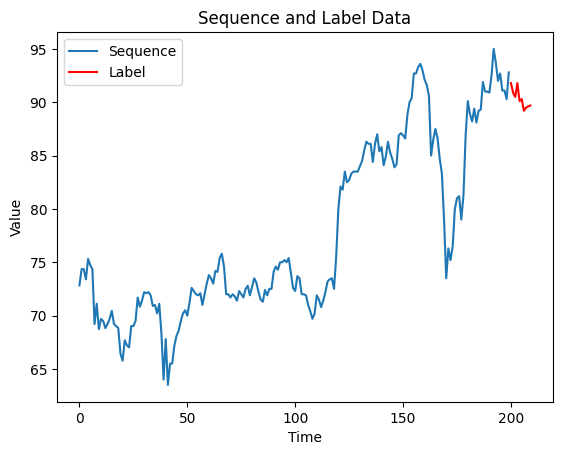

In [ ]:
# prompt: with traindataset[0] plot the second last column of its "seq" then add the "label" as the continue parts but different color

import matplotlib.pyplot as plt
sample = 100
# Extract the data from the dataset
seq_data = train_dataset[sample]["seq"][:, -5]  # Get the second-to-last column
label_data = train_dataset[sample]["label"]

# Combine the sequence and label data for plotting
combined_data = torch.cat((seq_data, label_data))

# Create the x-axis values for the plot
x_values = list(range(len(combined_data)))

# Plot the data
plt.plot(x_values[:len(seq_data)], seq_data, label="Sequence")
plt.plot(x_values[len(seq_data):], label_data, label="Label", color='red')

# Customize the plot
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Sequence and Label Data")
plt.legend()

# Display the plot
plt.show()


#### Define the Model class

In [62]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, seq_len = 10, future_len=2):
        super(Model, self).__init__()
        self.rnn = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            dropout=0.3,
            batch_first=True,
        )
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.future_len = future_len
        # self.fci = nn.Linear(seq_len * hidden_dim, 8)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

        # for name, param in self.rnn.named_parameters():
        #     if 'weight_ih' in name:
        #         # Input-to-hidden weights: Xavier Uniform Initialization
        #         nn.init.xavier_uniform_(param.data)
        #     elif 'weight_hh' in name:
        #         # Hidden-to-hidden weights: Orthogonal Initialization
        #         nn.init.orthogonal_(param.data)
        #     elif 'bias' in name:
        #         nn.init.constant_(param.data, 0)
    def forward(self, x):
        if self.rnn.batch_first is True:
            h0 = torch.zeros(
                self.num_layers, x.size(0), self.hidden_dim
            ).to(x.device)
            c0 = torch.zeros(
                self.num_layers, x.size(0), self.hidden_dim
            ).to(x.device)

        out, _ = self.rnn(x, (h0, c0))


        # out shape = (batch, seq, hidden_dim)
        # hi shape = (num_layers, batch, hidden_dim)

        out = out[:, -self.future_len:, :]
        # out = out.reshape(out.size(0), -1)
        # out = self.fci(out)
        # out = self.relu(out)

        out = self.fc(out)
        out = out.squeeze(-1)

        return out




#### Initialize the device, model, criterion, and optimizer


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(input_dim=5, hidden_dim=10, output_dim=1, num_layers=3, seq_len=seq_len, future_len=future_len).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
# prompt: printing every parameters in model

for name, param in model.named_parameters():
  print(f"Parameter Name: {name}")
  print(f"Parameter Shape: {param.shape}")
  print(f"Parameter Data: {param}")
  print("-" * 30)


Parameter Name: rnn.weight_ih_l0
Parameter Shape: torch.Size([40, 6])
Parameter Data: Parameter containing:
tensor([[ 0.0501, -0.2013, -0.1682,  0.3300,  0.2769, -0.0956],
        [ 0.1901, -0.2769, -0.3447, -0.2941, -0.2366,  0.1571],
        [ 0.3135, -0.3149,  0.1127,  0.0796, -0.1858, -0.0876],
        [-0.1222, -0.2059, -0.2972, -0.0046,  0.2843,  0.0954],
        [ 0.1663, -0.1911,  0.1736, -0.2415, -0.1890, -0.3253],
        [ 0.0427, -0.2205, -0.3354, -0.2457,  0.1416,  0.3277],
        [ 0.1475, -0.0922, -0.2599,  0.2408,  0.3350, -0.2260],
        [ 0.3209, -0.1037, -0.3424, -0.3106, -0.2247,  0.1750],
        [ 0.1503, -0.1931, -0.1144,  0.3607,  0.1988,  0.2353],
        [ 0.0155, -0.1859, -0.2583,  0.2436,  0.0176,  0.0479],
        [-0.2088,  0.2733, -0.0574,  0.1297, -0.0993,  0.2884],
        [-0.1548, -0.1351,  0.2031, -0.3344,  0.3191, -0.2981],
        [-0.1127, -0.2395, -0.1971,  0.2866,  0.1552, -0.2340],
        [ 0.2739, -0.0670,  0.0162, -0.0089, -0.3313,  0.344

#### Train the model

In [65]:
epochs = 100
model.train()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    with tqdm(dataloader, unit="step", ncols=100, desc=f"Epoch {epoch + 1}/{epochs}") as tepoch:
        for batch in tepoch:
            seq = batch["seq"].to(device)
            label = batch["label"].to(device)
            # print(seq.shape, label.shape)
            # seq = seq.unsqueeze(-1)
            out = model(seq)
            loss = criterion(out, label)
            running_loss += loss.item()
            # if (epoch+1) % 1 == 0:
            #     for name, param in model.rnn.named_parameters():
            #         if param.requires_grad:
            #             print(f"Parameter: {name}, Gradient: {param.grad:.10f}")
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            tepoch.set_postfix(loss=f"{loss.item():.5f}")
    running_loss /= len(dataloader)
    if (epoch+1) % 5 == 0:
        # for name, param in model.rnn.named_parameters():
        #     if param.requires_grad:
        #         print(f"Parameter: {name}, Gradient: {param.grad.max():.10f}, {param.grad.min():.10f}")
        model.eval()
        with torch.inference_mode():
            testing_loss = 0.0
            for i, batch in enumerate(testloader):
                seq = batch["seq"].to(device)
                label = batch["label"].to(device)
                # seq = seq.unsqueeze(-1)
                out = model(seq)
                loss = criterion(out, label)
                testing_loss += loss.item()
            # for pred, act in zip(out[:5], label[:5]):
                # print(f"Pred: {pred}, Actual: {act}")

            print(
                f"Test: {testing_loss / (len(testloader)):.5f}, Loss: {running_loss:.5f}"
            )




Epoch 5/100: 100%|██████████████████████████████████| 42/42 [00:01<00:00, 37.05step/s, loss=0.01933]


Test: 0.02488, Loss: 0.03205


Epoch 10/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 36.72step/s, loss=0.01801]


Test: 0.01864, Loss: 0.02163


Epoch 15/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 34.04step/s, loss=0.01310]


Test: 0.01744, Loss: 0.02050


Epoch 20/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 21.66step/s, loss=0.01771]


Test: 0.01625, Loss: 0.01919


Epoch 25/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 40.49step/s, loss=0.02618]


Test: 0.01316, Loss: 0.01708


Epoch 30/100: 100%|█████████████████████████████████| 42/42 [00:00<00:00, 43.00step/s, loss=0.00593]


Test: 0.02305, Loss: 0.01816


Epoch 35/100: 100%|█████████████████████████████████| 42/42 [00:00<00:00, 44.88step/s, loss=0.00958]


Test: 0.01427, Loss: 0.01356


Epoch 40/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 31.87step/s, loss=0.00669]


Test: 0.00963, Loss: 0.01142


Epoch 45/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 40.94step/s, loss=0.00945]


Test: 0.01164, Loss: 0.01374


Epoch 50/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 38.34step/s, loss=0.01246]


Test: 0.00961, Loss: 0.00995


Epoch 55/100: 100%|█████████████████████████████████| 42/42 [00:00<00:00, 43.99step/s, loss=0.01254]


Test: 0.00964, Loss: 0.01011


Epoch 60/100: 100%|█████████████████████████████████| 42/42 [00:00<00:00, 43.89step/s, loss=0.00419]


Test: 0.01436, Loss: 0.01012


Epoch 65/100: 100%|█████████████████████████████████| 42/42 [00:00<00:00, 46.30step/s, loss=0.00748]


Test: 0.00817, Loss: 0.00787


Epoch 70/100: 100%|█████████████████████████████████| 42/42 [00:00<00:00, 43.95step/s, loss=0.04671]


Test: 0.00773, Loss: 0.00870


Epoch 75/100: 100%|█████████████████████████████████| 42/42 [00:00<00:00, 45.93step/s, loss=0.02660]


Test: 0.00870, Loss: 0.00979


Epoch 80/100: 100%|█████████████████████████████████| 42/42 [00:02<00:00, 19.80step/s, loss=0.00600]


Test: 0.00679, Loss: 0.00648


Epoch 85/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 23.55step/s, loss=0.00852]


Test: 0.00748, Loss: 0.00628


Epoch 90/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 35.42step/s, loss=0.00193]


Test: 0.00712, Loss: 0.00548


Epoch 95/100: 100%|█████████████████████████████████| 42/42 [00:01<00:00, 34.44step/s, loss=0.00722]


Test: 0.00872, Loss: 0.00967


Epoch 100/100: 100%|████████████████████████████████| 42/42 [00:01<00:00, 33.27step/s, loss=0.00310]


Test: 0.00564, Loss: 0.00510


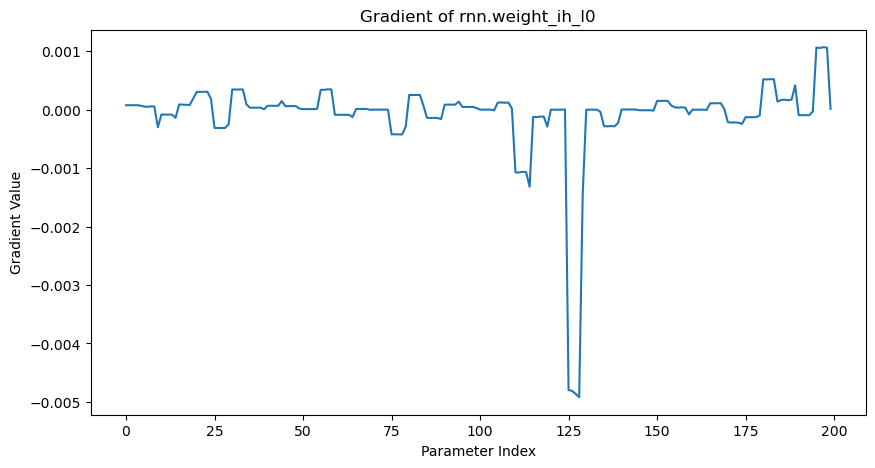

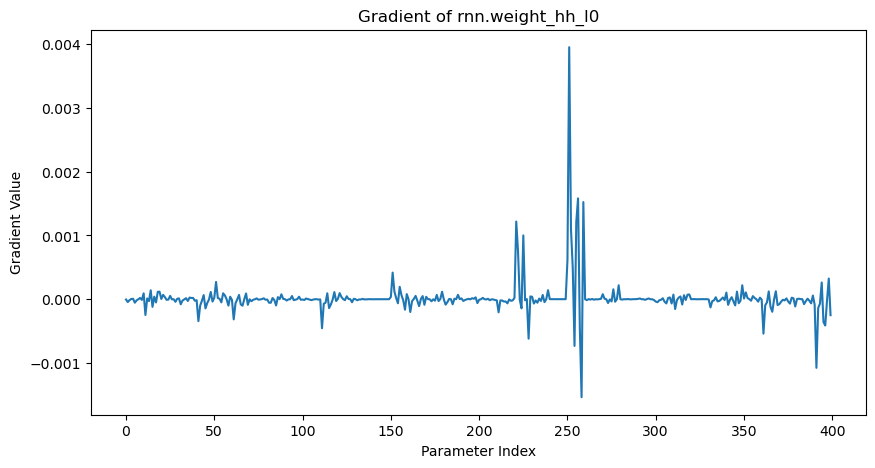

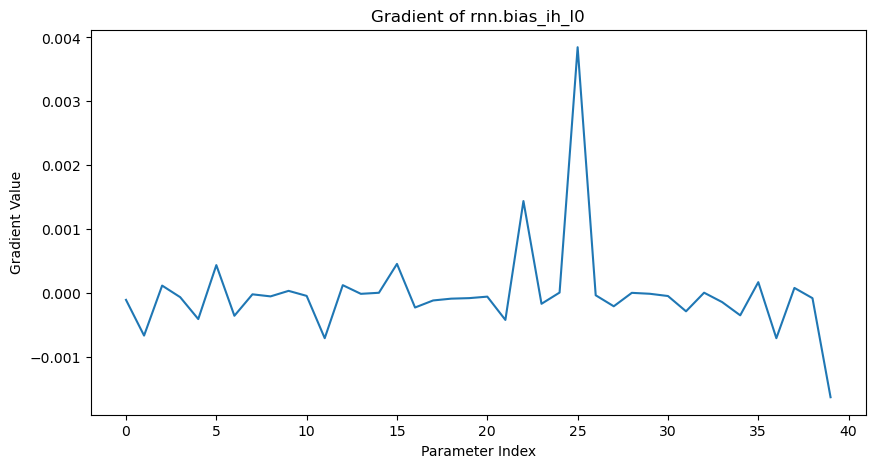

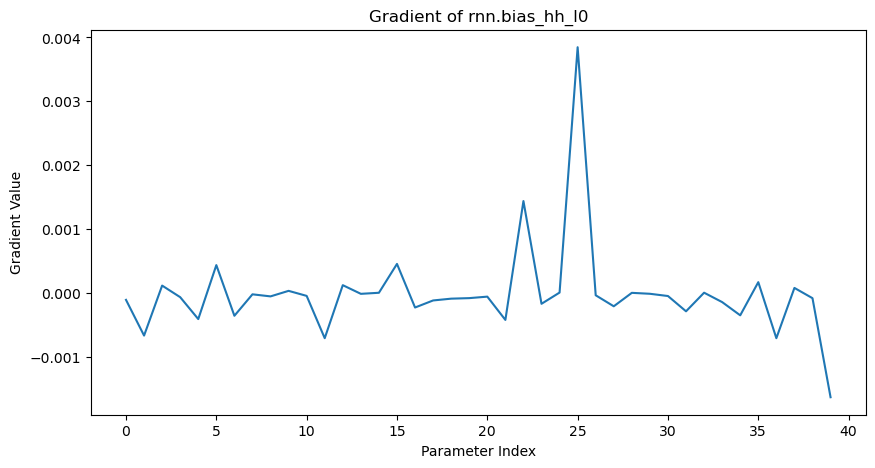

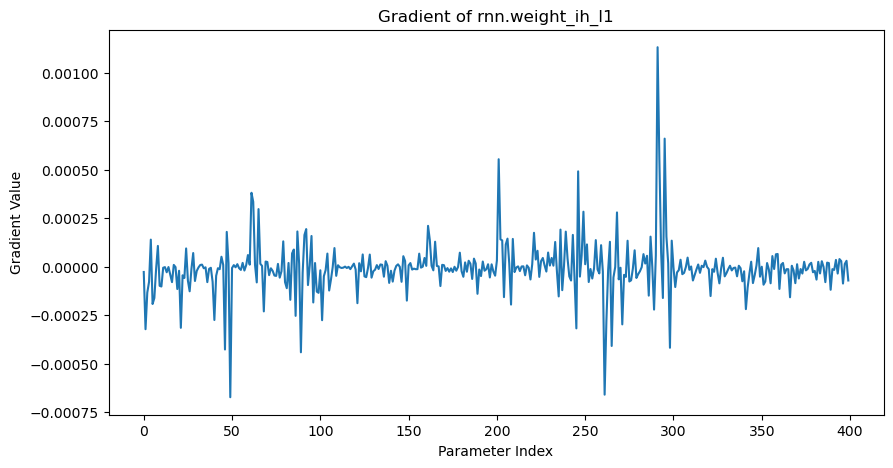

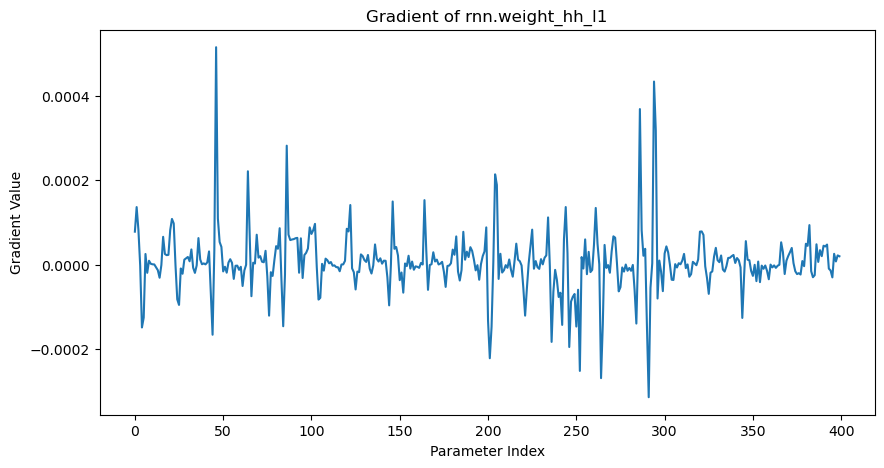

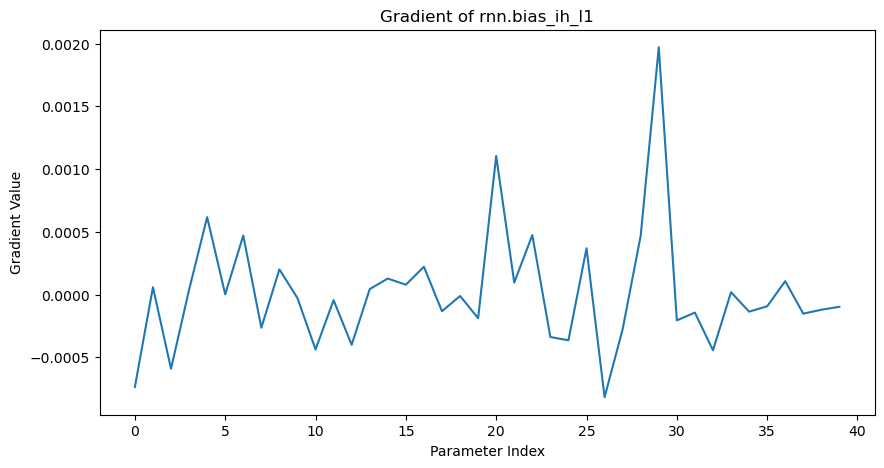

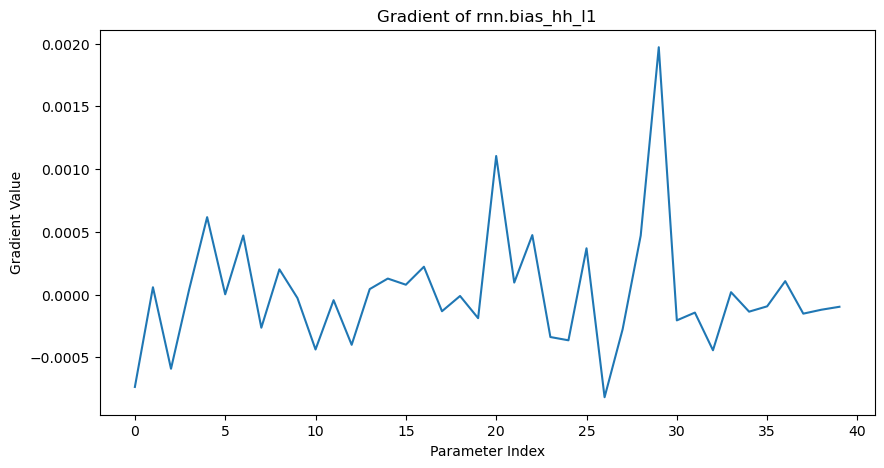

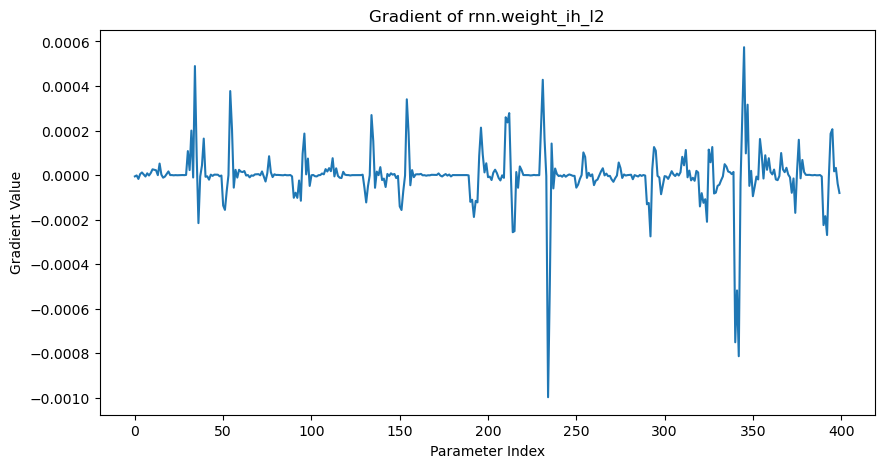

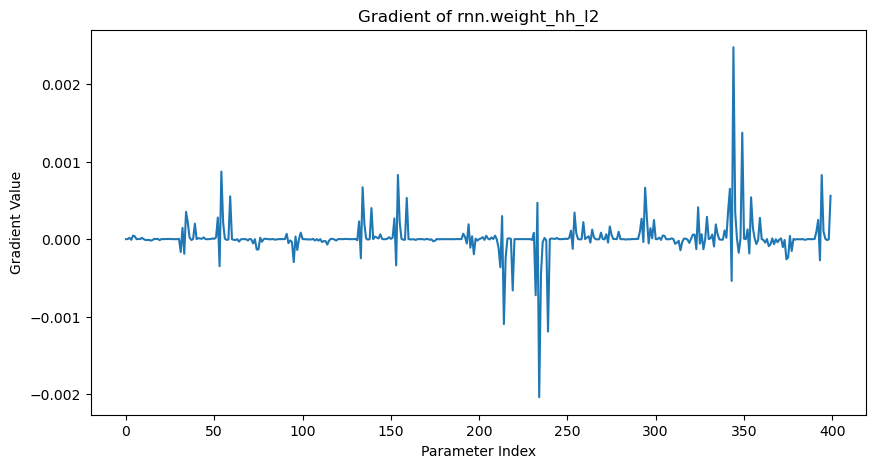

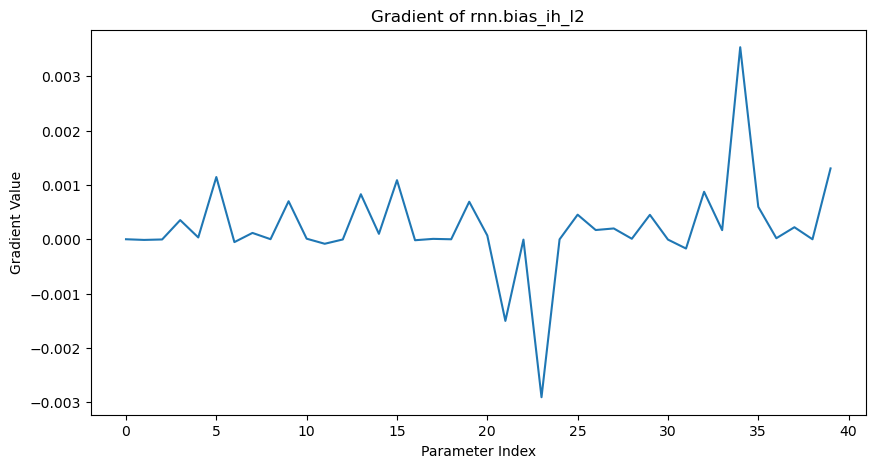

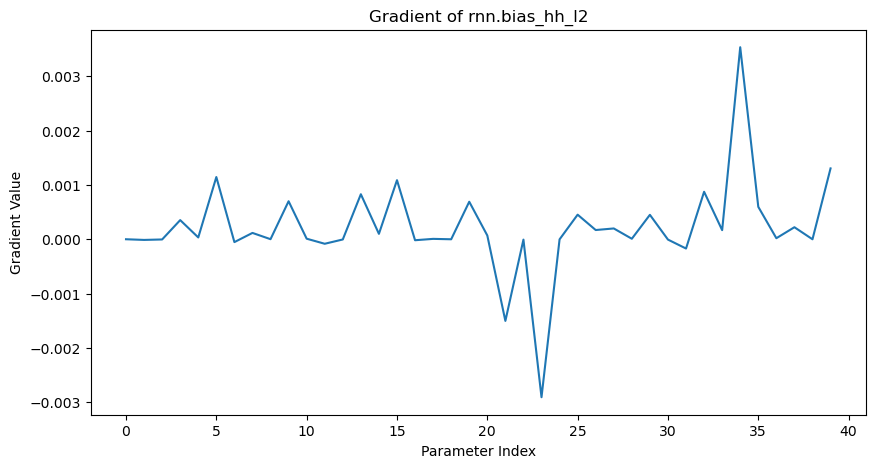

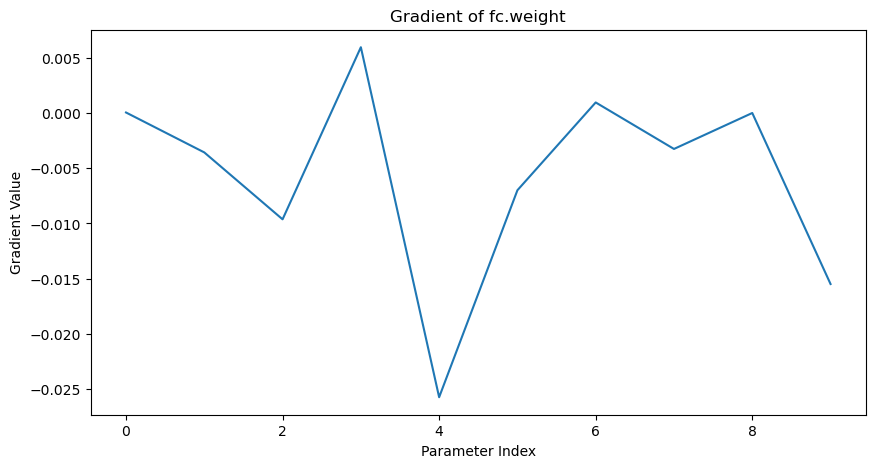

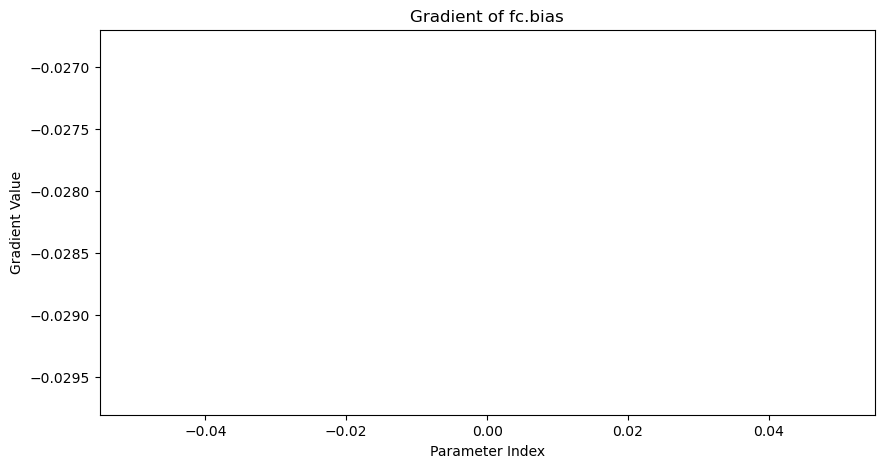

In [52]:
# prompt: plot the params gradient of model

def plot_gradients(model):
  """Plots the gradients of the model's parameters."""
  for name, param in model.named_parameters():
    if param.grad is not None:
      plt.figure(figsize=(10, 5))
      plt.plot(param.grad.cpu().numpy().flatten())
      plt.title(f"Gradient of {name}")
      plt.xlabel("Parameter Index")
      plt.ylabel("Gradient Value")
      plt.show()


# After training for a few epochs, call the function:
plot_gradients(model)


In [10]:
for name, param in model.rnn.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Gradient: {param.grad.max():.20f}, {param.grad.mean():.20f}, {param.grad.min():.20f}")

Parameter: weight_ih_l0, Gradient: 0.00752703240141272545, 0.00017732774722389877, -0.01118598040193319321
Parameter: weight_hh_l0, Gradient: 0.00203581969253718853, 0.00005208863876760006, -0.00143826485145837069
Parameter: bias_ih_l0, Gradient: 0.00705593032762408257, 0.00040837409324012697, -0.00480675091966986656
Parameter: bias_hh_l0, Gradient: 0.00705593032762408257, 0.00040837409324012697, -0.00480675091966986656
Parameter: weight_ih_l1, Gradient: 0.00344270491041243076, 0.00009639235940994695, -0.00462308572605252266
Parameter: weight_hh_l1, Gradient: 0.00316850631497800350, 0.00005369458813220263, -0.00547775533050298691
Parameter: bias_ih_l1, Gradient: 0.00823057908564805984, -0.00071453227428719401, -0.00724624656140804291
Parameter: bias_hh_l1, Gradient: 0.00823057908564805984, -0.00071453227428719401, -0.00724624656140804291


In [35]:
model.eval()
with torch.inference_mode():
    eval_dataset = DataLoader(dataset, batch_size=1, shuffle=False)
    scaler = dataset.Scaler
    for i, batch in enumerate(eval_dataset):
        X_eval = batch["seq"].to(device)
        y_eval = batch["truth"].to(device)

        y_pred = model(X_eval)
        print(y_pred[0, 0], y_eval.shape)
        reverse_pred = np.repeat(y_pred[0, 0].cpu().numpy(), 8, axis=0).reshape(1, -1)
        print(scaler.inverse_transform(reverse_pred)[0, -5], y_eval[0, 0])
        # dataset.Scaler.inverse_transform()
        break

tensor(-0.6632) torch.Size([1, 10])
7.0520244 tensor(6.4100)


[6.2147517, 6.2096047, 6.2067304, 6.204274, 6.2016892, 6.2049904, 6.205412, 6.2029057, 6.1991515, 6.196034, 6.1940575, 6.191976, 6.195356, 6.248864, 6.291807, 6.3147564, 6.338829, 6.348853, 6.3597317, 6.3606954, 6.364241, 6.364524, 6.3661504, 6.366238, 6.368903, 6.437853, 6.480852, 6.501164, 6.5175514, 6.5163836, 6.4988484, 6.4879594, 6.4738836, 6.4593725, 6.45058, 6.434592, 6.4259753, 6.4139757, 6.399513, 6.384476, 6.36962, 6.355053, 6.343029, 6.36209, 6.3794155, 6.4357195, 6.4680667, 6.476201, 6.4773135, 6.4653487, 6.4476094, 6.443053, 6.431859, 6.413913, 6.3947425, 6.3783174, 6.3658714, 6.360226, 6.349639, 6.3392286, 6.3265557, 6.3166013, 6.3042264, 6.291429, 6.2806096, 6.2723927, 6.257126, 6.2397566, 6.223452, 6.2073298, 6.190161, 6.17629, 6.1623893, 6.145518, 6.128941, 6.114965, 6.099697, 6.0865583, 6.075086, 6.061684, 6.049045, 6.036745, 6.031128, 6.0206876, 6.0035553, 5.987002, 5.9758224, 5.9642854, 5.954756, 5.9447308, 5.935853, 5.927264, 5.9192896, 5.913774, 5.9088655, 5.90331

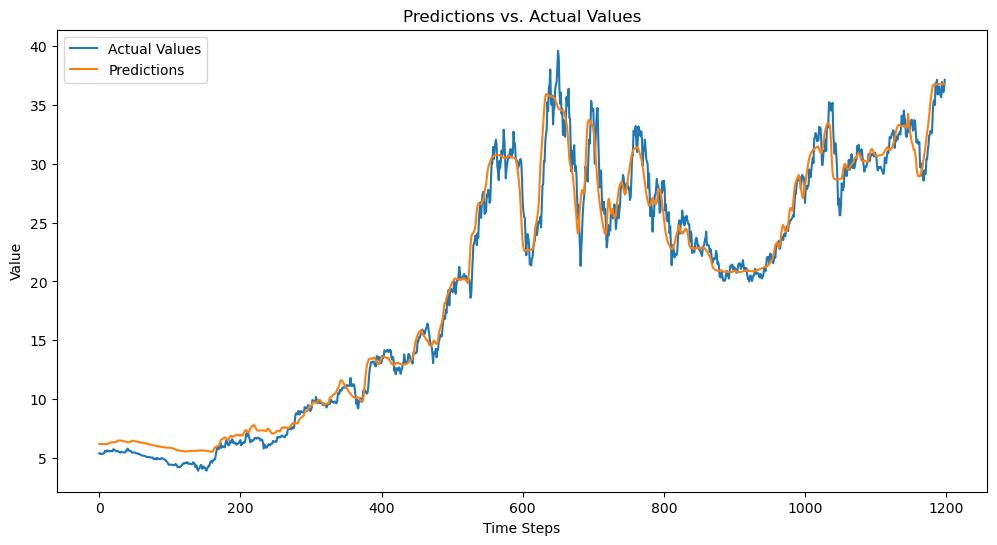

In [68]:
# prompt: use model to predict all dataset and plot it
import numpy as np
eval_dataset = DataLoader(dataset, batch_size=1, shuffle=False)
model.eval()
with torch.inference_mode():
    predictions = []
    actual_values = []
    for i, batch in enumerate(eval_dataset):
        if i < 1000:
            continue
        seq = batch["seq"].to(device)
        label = batch["label"].to(device)
        truth = batch["truth"].to(device)
        # seq = seq.unsqueeze(-1)
        out = model(seq)
        # print(out)
        reverse_pred = np.repeat(out[0, -5].cpu().numpy(), 5, axis=0).reshape(1, -1)
        # print(reverse_pred)
        # print(scaler.inverse_transform(reverse_pred)[0, -5], y_eval[0, 0])
        truth_pred = dataset.Scaler.inverse_transform(reverse_pred)[0, -2]
        predictions.append(truth_pred)
        actual_values.append(truth[0, 0].cpu().numpy())
        # print(f"Pred: {truth_pred[-1, -5]}, Actual: {truth[-1, -1]}")

print(predictions)
print(actual_values)


# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual Values")
plt.plot(predictions, label="Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Predictions vs. Actual Values")
plt.legend()
plt.show()
